In [1]:
!pip install transformers datasets transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 23.2 MB/s eta 0:00:00


In [11]:
!unzip validation.zip
!unzip train.zip
!mkdir datasets
!mv train datasets
!mv validation datasets

mkdir: cannot create directory ‘datasets’: File exists
mv: invalid option -- 'r'
Try 'mv --help' for more information.
mv: invalid option -- 'r'
Try 'mv --help' for more information.


# **Finetuning of Deep Learning Model**

In [149]:
import os

from transformers import pipeline
from transformers import Trainer, TrainingArguments
from transformers import DefaultDataCollator
from datasets import load_dataset
from transformers import AutoImageProcessor, ResNetModel
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [150]:
data_dir = 'datasets'
train_dir = data_dir + '/train'
val_dir = data_dir + '/validation'

img_height,img_width=50,50
batch_size=32
seed = 123

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  subset="training",
  validation_split=0.2,
  seed=seed,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  subset="validation",
  validation_split=0.2,
  seed=seed,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  seed=seed,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 2723 files belonging to 2 classes.
Using 2179 files for training.
Found 2723 files belonging to 2 classes.
Using 544 files for validation.
Found 355 files belonging to 2 classes.


In [151]:
class_names = train_ds.class_names
print(class_names)

['no_pools', 'pools']


In [152]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(
                    include_top=False,
                    input_shape=(img_height,img_width,3),
                    pooling='avg',classes=len(class_names),
                    weights='imagenet'
                  )

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

In [153]:
resnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_24 (ModuleWr  (None, 2048)             0         
 apper)                                                          
                                                                 
 module_wrapper_25 (ModuleWr  (None, 512)              1049088   
 apper)                                                          
                                                                 
 module_wrapper_26 (ModuleWr  (None, 1)                513       
 apper)                                                          
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
__________________________________

In [154]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.resnet.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

In [155]:
epochs=10
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

Epoch 1/10
69/69 [==============================] - 48s 637ms/step - loss: 0.3261 - accuracy: 0.9045 - val_loss: 0.1892 - val_accuracy: 0.9283
Epoch 2/10
69/69 [==============================] - 40s 583ms/step - loss: 0.0782 - accuracy: 0.9679 - val_loss: 0.2008 - val_accuracy: 0.9228
Epoch 3/10
69/69 [==============================] - 40s 585ms/step - loss: 0.0488 - accuracy: 0.9816 - val_loss: 0.1654 - val_accuracy: 0.9467
Epoch 4/10
69/69 [==============================] - 40s 577ms/step - loss: 0.0261 - accuracy: 0.9904 - val_loss: 0.1648 - val_accuracy: 0.9504
Epoch 5/10
69/69 [==============================] - 40s 581ms/step - loss: 0.0090 - accuracy: 0.9986 - val_loss: 0.1605 - val_accuracy: 0.9522
Epoch 6/10
69/69 [==============================] - 57s 828ms/step - loss: 0.0079 - accuracy: 0.9991 - val_loss: 0.1759 - val_accuracy: 0.9504
Epoch 7/10
69/69 [==============================] - 40s 581ms/step - loss: 0.0033 - accuracy: 0.9995 - val_loss: 0.1686 - val_accuracy: 0.9559

### **Validación**

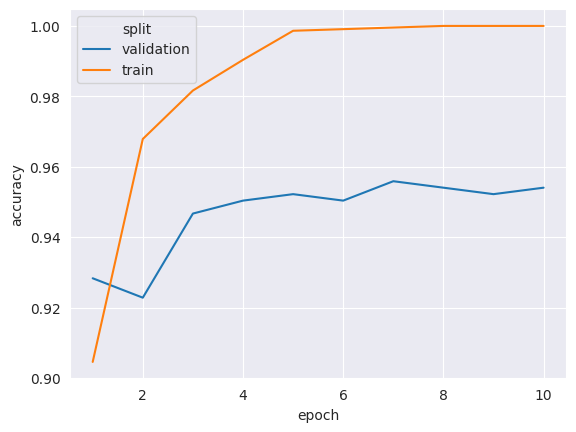

In [157]:
import seaborn as sns

data = {'epoch': [], 'accuracy': [], 'split': []}
for idx, val_acc in enumerate(history.history['val_accuracy']):
  data['split'].append('validation')
  data['accuracy'].append(val_acc)
  data['epoch'].append(idx+1)
for idx, train_acc in enumerate(history.history['accuracy']):
  data['split'].append('train')
  data['accuracy'].append(train_acc)
  data['epoch'].append(idx+1)

sns.set_style('darkgrid')
sns.lineplot(data=data, x='epoch', y='accuracy', hue='split');

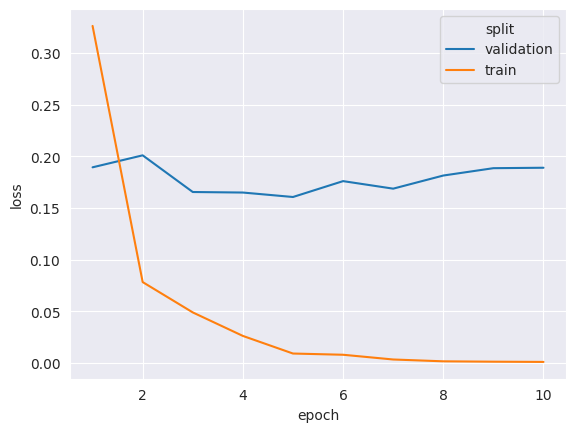

In [158]:
data = {'epoch': [], 'loss': [], 'split': []}
for idx, val_loss in enumerate(history.history['val_loss']):
  data['split'].append('validation')
  data['loss'].append(val_loss)
  data['epoch'].append(idx+1)
for idx, train_loss in enumerate(history.history['loss']):
  data['split'].append('train')
  data['loss'].append(train_loss)
  data['epoch'].append(idx+1)

sns.set_style('darkgrid')
sns.lineplot(data=data, x='epoch', y='loss', hue='split');

## **Evaluación**

### **Dataset principal**

In [159]:
pred = resnet_model.predict(test_ds)

12/12 [==============================] - 7s 527ms/step


In [160]:
labels = [int(l) for _, labels in test_ds for l in labels]
pred_y = [x[0] for x in pred]
pred_y = np.round(pred_y).astype(int)

In [161]:
cr = classification_report(pred_y, labels)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       166
           1       0.97      0.92      0.95       189

    accuracy                           0.94       355
   macro avg       0.94      0.95      0.94       355
weighted avg       0.95      0.94      0.94       355



In [162]:
cm = confusion_matrix(labels, pred_y)

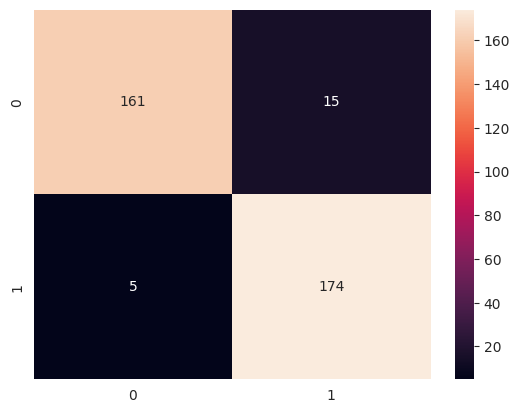

In [163]:
sns.heatmap(cm, annot=True, fmt='');

### **Dataset de algarves**

In [ ]:
!unzip formatted_dataset.zip

In [175]:
algarves_formatted_test_dir = 'formatted_dataset'

algarves_ds_formatted = tf.keras.preprocessing.image_dataset_from_directory(
  algarves_formatted_test_dir,
  seed=seed,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 289 files belonging to 2 classes.


In [176]:
pred = resnet_model.predict(algarves_ds_formatted)

10/10 [==============================] - 6s 475ms/step


In [177]:
labels = [int(l) for _, labels in algarves_ds_formatted for l in labels]
pred_y = [x[0] for x in pred]
pred_y = np.round(pred_y).astype(int)

In [178]:
cr = classification_report(pred_y, labels)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       106
           1       0.93      0.87      0.90       183

    accuracy                           0.88       289
   macro avg       0.87      0.88      0.87       289
weighted avg       0.88      0.88      0.88       289



In [179]:
cm = confusion_matrix(labels, pred_y)

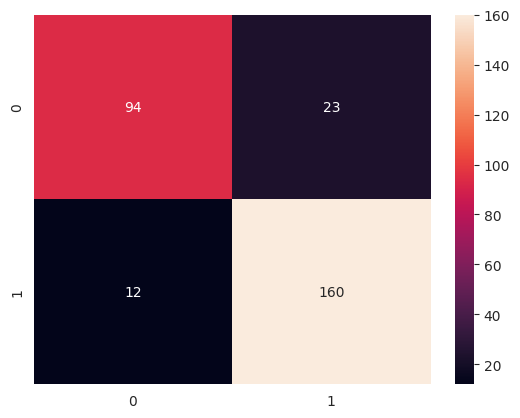

In [180]:
sns.heatmap(cm, annot=True, fmt='');

### **Dataset de algarves fragmentado**

In [164]:
!unzip fragmented_dataset.zip

Archive:  fragmented_dataset.zip
replace fragmented_dataset/no_pools/1.PNG_50x50_0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [165]:
algarves_test_dir = 'fragmented_dataset'

algarves_ds = tf.keras.preprocessing.image_dataset_from_directory(
  algarves_test_dir,
  seed=seed,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 2199 files belonging to 2 classes.


In [166]:
pred = resnet_model.predict(algarves_ds)

69/69 [==============================] - 30s 428ms/step


In [167]:
labels = [int(l) for _, labels in algarves_ds for l in labels]
pred_y = [x[0] for x in pred]
pred_y = np.round(pred_y).astype(int)

In [168]:
cr = classification_report(pred_y, labels)
print(cr)

              precision    recall  f1-score   support

           0       0.72      0.99      0.84      1349
           1       0.97      0.40      0.57       850

    accuracy                           0.76      2199
   macro avg       0.84      0.70      0.70      2199
weighted avg       0.82      0.76      0.73      2199



In [169]:
cm = confusion_matrix(labels, pred_y)

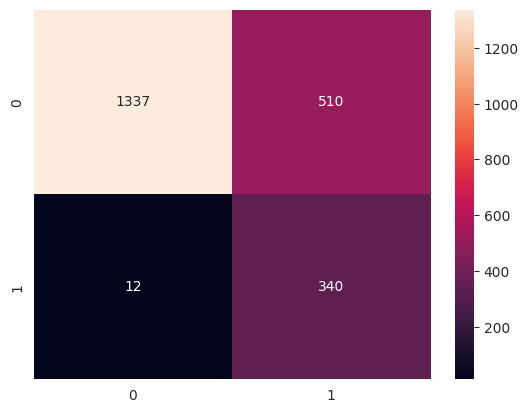

In [170]:
sns.heatmap(cm, annot=True, fmt='');